### Dask SVD Compressed Benchmark

Quick check to see how transposition of arrays affects SVD performance.

In [1]:
import tqdm
import pandas as pd
import numpy as np
import plotnine as pn
import dask.array as da
from dask.array.linalg import svd_compressed

In [2]:
def run(x, k):
    u, s, v = svd_compressed(x, k=k, n_power_iter=4, compute=True, seed=1)
    return (u.mean() + v.mean()).compute()

def benchmark():
    df = []
    # Create arrays with `n` elements, a fraction 
    # `s` of which become rows and the rest columns
    for arg in tqdm.tqdm([
        (n, s)
        for n in [1000, 10000, 100000, 300000]
        for s in [.1, .2, .4, .5, .6, .8, .9]
    ]):
        n, s = arg
        m = int(n * s)
        n = n - m
        k = 10
        x = da.random.random((m, n), chunks='auto')
        r = %timeit -n 1 -r 1 -o -q run(x, k=k)
        df.append(dict(m=m, n=n, k=k, s=s, time=r.average))
    return pd.DataFrame(df)

In [3]:
%%time
df = benchmark()

100%|██████████| 28/28 [18:06<00:00, 38.82s/it] 

CPU times: user 4h 13min 21s, sys: 23min 44s, total: 4h 37min 5s
Wall time: 18min 6s


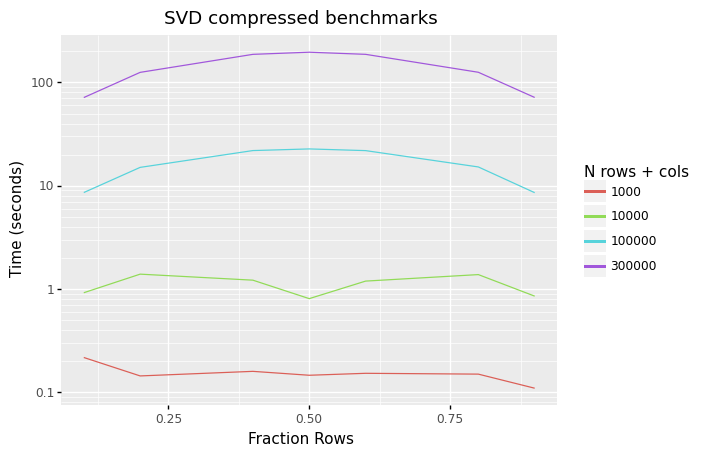

<ggplot: (8738542056949)>

In [12]:
(
    pn.ggplot(
        df.assign(t=lambda df: df.m + df.n).assign(s=lambda df: df.m / df.t)
        .assign(color=lambda df: df.t.astype(str)),
        pn.aes(x='s', y='time', color='color')
    ) + 
    pn.geom_line() +
    pn.scale_y_log10() + 
    pn.labs(
        title='SVD compressed benchmarks',
        x='Fraction Rows',
        y='Time (seconds)',
        color='N rows + cols'
    )
)